# Import

In [1]:
from IPython.display import clear_output
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
from IPython import display
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
import inspect
import tensorboard
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
import itertools
import matplotlib.colors as mcolors
import glob, os

In [2]:
import xr_data_transform

In [3]:
import logging
logging.getLogger('lightning').setLevel(0)
pl.utilities.distributed.log.setLevel(logging.ERROR)

In [4]:
import platform
print(platform.platform())

Linux-5.10.133+-x86_64-with-glibc2.35


In [5]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Useful functions

In [6]:
line_styles = ['solid', 'dashed', 'dotted', 'dashdot']

For testing

In [7]:
def central_diffs_x(dataArray) :
    return 0.5*(torch.roll(dataArray, shifts=-1, dims=0) - torch.roll(dataArray, shifts=1, dims=0))
def central_diffs_y(dataArray) :
    return 0.5*(torch.roll(dataArray, shifts=-1, dims=1) - torch.roll(dataArray, shifts=1, dims=1))

In [8]:
def central_diffs_x_2(dataArray) :
    return (torch.roll(dataArray, shifts=-1, dims=0) - 2.*dataArray.clone() + torch.roll(dataArray, shifts=1, dims=0))
def central_diffs_y_2(dataArray) :
    return (torch.roll(dataArray, shifts=-1, dims=1) - 2.*dataArray.clone() + torch.roll(dataArray, shifts=1, dims=1))

In [9]:
def finite_diffs_sqr_2d_array(dataArray) :
    return torch.pow(central_diffs_x(dataArray),2) + torch.pow(central_diffs_y(dataArray),2)
    #return (central_diffs_y(dataArray)).clone()
    #return torch.pow(central_diffs_x_2(dataArray),2) + torch.pow(central_diffs_y_2(dataArray),2)

A function that allows to read the logs in tensorboars format and returns them as a python dictionary:

In [10]:
def get_logs_from_tb(exp_name, version_name, directory='logs/') :
    dictionary = dict()
    # for var in list_of_vars :
    #     dictionary[var] = list()
    file_name = glob.glob(directory + '/' + exp_name + '/' + version_name + '/events.out.*')[-1]
    print(file_name)
    for event in EventFileLoader(file_name).Load() :
        if (len(event.summary.value) > 0) :
            if (event.summary.value[0].tag not in dictionary) :
                dictionary[event.summary.value[0].tag] = []
            (dictionary[event.summary.value[0].tag]).append(event.summary.value[0].tensor.float_val)
    return dictionary

# Data properties

In [11]:
time_slice = dict(time_counter=slice(0,-1,None))

In [12]:
data_dict=[dict() for i in range(6)]
data_dict[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA', 'xy_slice' : dict(x=slice(-380,-10),y=slice(-385,-15)), 'time_slice' : time_slice})
data_dict[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO', 'xy_slice' : dict(x=slice(-380,-10),y=slice(-385,-15)), 'time_slice' : time_slice})
data_dict[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL FMA', 'xy_slice' : dict(x=slice(-565,-195),y=slice(-385,-15)), 'time_slice' : time_slice})
data_dict[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL ASO', 'xy_slice' : dict(x=slice(-565,-195),y=slice(-385,-15)), 'time_slice' : time_slice})
data_dict[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA', 'xy_slice' : dict(x=slice(-370,None),y=slice(120,490)), 'time_slice' : time_slice})
data_dict[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO', 'xy_slice' : dict(x=slice(-370,None),y=slice(120,490)), 'time_slice' : time_slice})

In [13]:
features_to_add_to_sample = ['sigma0_model', 'sosstsst', 'sosaline', 'diff_sosaline_sqr', 'rho_sa_sa', 'rho_sa_ct', 'diff_sosstsst_sqr', 'rho_ct_ct',\
                             'diff_sigma0_delta_sqr',\
                             'predictor_T', 'predictor_S', 'predictor_TS',\
                             'sigma0_delta']

In [14]:
h = 24 # height of images
w = 24 # width of images

In [15]:
batch_size = 4

Create LR database

Evaluation loss function:

In [16]:
# %%time
# xr_data_transform.read_and_perform_transform("tcp://127.0.0.1:41943", data_dict)

Loss function or testing:

In [17]:
eval_loss = torch.nn.MSELoss(reduction='none') 
#eval_loss = torch.nn.L1Loss(reduction='none') 

# Data classes

## Pytorch dataset

In [18]:
class SalinityTemperatureDensityDataset(torch.utils.data.Dataset):
    """Dataset of 2D maps of surface temperature, salinity"""

    def __init__(self, xarray_dataset, select='All', portion_of_time_series=0.5, transform=None):
        self.transform = transform
        full_data_file_len = len(xarray_dataset['time_counter'])
        if (select == 'All') :
            time_index_range = np.arange(0, data_file_len)
        elif (select == 'First') :
            time_index_range = np.arange(0, int(portion_of_time_series*full_data_file_len)+1)
        elif (select == 'Last') :
            time_index_range = np.arange(int((1-portion_of_time_series)*full_data_file_len), full_data_file_len)
        self.data = xarray_dataset.isel(x=slice(None,w), y=slice(None,h), time_counter=time_index_range)
        self.data_file_len = len(self.data['time_counter'])
        
        # mean and std of the dataset (to avoid batch avg) for normalization and nan filling
        for feature in features_to_add_to_sample :
            self.data.attrs['mean_'+feature] = (self.data[feature].mean()).values
            self.data.attrs['std_'+feature] = (self.data[feature].std()).values
            self.data.attrs['median_'+feature] = (self.data[feature].median()).values
            self.data[feature] = (self.data[feature].fillna(self.data.attrs['median_'+feature])) # fill nans
            self.data['normalized_'+feature] = ((self.data[feature]-self.data.attrs['mean_'+feature])/self.data.attrs['std_'+feature])
        
    def __len__(self):
        return self.data_file_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            list_idx = idx.tolist()
        else :
            list_idx = idx
        selected_time_frames = self.data.isel(time_counter=list_idx)
        
        # create dictionary of a sample (a batch) containig different features. 
        # This dictionary is sort of an intermediate step, preparing xArray data for trasform into pytorch tensors
        sample = dict()
        for feature in features_to_add_to_sample :
            sample['mean_'+feature] = self.data.attrs['mean_'+feature]
            sample['std_'+feature] = self.data.attrs['std_'+feature]
            sample[feature] = selected_time_frames[feature].values
            sample['normalized_'+feature] = selected_time_frames['normalized_'+feature].values
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def restore_units(tensor, sample, reference_feature) :
        return tensor*(sample['std_'+reference_feature].view(-1,1,1))+sample['mean_'+reference_feature].view(-1,1,1)
                
    def normalize(tensor, sample, reference_feature) :
        return (tensor-sample['mean_'+reference_feature].view(-1,1,1))/(sample['std_'+reference_feature].view(-1,1,1))

In [19]:
class ToTensor(object):
    """Convert each numpy array in sample to Tensors."""

    def __call__(self, sample):
        transformed_sample=sample.copy()
        for feature in features_to_add_to_sample :
            transformed_sample[feature] = torch.tensor(sample[feature])
        return transformed_sample

## PyLi data module

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models.

In [20]:
from pytorch_lightning.trainer.supporters import CombinedLoader

class PyLiDataModule(pl.LightningDataModule):
    def __init__(self, cloud_data_sets, batch_size):
        super().__init__()
        self.cloud_data_sets = cloud_data_sets
        self.batch_size = batch_size
        
    def prepare_data(self):
        self.list_of_xr_datasets = [xr.open_dataset('/tmp/dataset'+str(i)+'.nc') for i in range(len(self.cloud_data_sets))]
                
    def train_dataloader(self):
        # takes first 60% of time snapshots for training
        train_datasets = torch.utils.data.ConcatDataset([SalinityTemperatureDensityDataset(xr_dataset, select='First', portion_of_time_series=0.6, transform=ToTensor()) \
                           for xr_dataset in self.list_of_xr_datasets])
        return torch.utils.data.DataLoader(train_datasets, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=0)
    
    def val_dataloader(self):
        # takes last 20% of time snapshots for validation
        val_datasets = torch.utils.data.ConcatDataset([SalinityTemperatureDensityDataset(xr_dataset, select='Last', portion_of_time_series=0.2, transform=ToTensor()) \
                          for xr_dataset in self.list_of_xr_datasets])
        return torch.utils.data.DataLoader(val_datasets, batch_size=self.batch_size, drop_last=True, num_workers=0) 
    
    def test_dataloader(self):
        test_datasets = [SalinityTemperatureDensityDataset(xr_dataset, select='Last', portion_of_time_series=0.2, transform=ToTensor()) \
                          for xr_dataset in self.list_of_xr_datasets]
        return [torch.utils.data.DataLoader(dataset, batch_size=1, drop_last=True, num_workers=0) for dataset in test_datasets]

## Initialize datamodule

In [21]:
datamodule = PyLiDataModule(data_dict, batch_size=batch_size)

# PyTorch Lightning Module

In [1]:
class GenericPyLiModule(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs, \
                 loss=torch.nn.MSELoss(), \
                 optimizer=torch.optim.Adam(self.parameters(), lr=1e-4) ):
        super().__init__()
        self.nnModel = nnModel
        self.inputs = inputs
        self.outputs = outputs
        self.loss = loss
        self.save_hyperparameters(ignore=['nnModel'])
        self.optimizer=optimizer
        
        ## initialization of weights
        #nnModel.weight.data = torch.Tensor([1.0])

    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = self.loss(y_model, y_true)  
        self.log_dict({'loss_train' : loss, 'coef_train' : self.nnModel.weight.data[:,0]}, on_step=False, on_epoch=True)
        return loss

    # validation logics (is evaluated during the training, but the data is not used to the optimization loop)
    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = self.loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    # gives model output in a form of a dictionary of 2d variables
    def predict_step(self, batch, batch_idx, dataloader_idx) :
        output_h = h-2
        output_w = w-2
        batch_len = len(batch[self.outputs[0]])
        x = self.transform_input(batch)
        tensor_model_output = self.nnModel(x)
        output_unflatten = torch.permute(tensor_model_output.unflatten(dim=0, sizes=[batch_len,-1]),dims=(0,2,1))
        output_4d = torch.nn.functional.fold(output_unflatten, output_size=(output_h,output_w), kernel_size=1, dilation=1, padding=0, stride=1)
        pred = dict()
        for i, feature in enumerate(self.outputs) :
            pred[feature] = output_4d[:,i].view(-1,output_h,output_w)
            # if outputs are normalized then compute also result in the restored units (not normalized)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                pred[not_normalized_feature] = SalinityTemperatureDensityDataset.restore_units(pred[feature], batch, not_normalized_feature)
        return pred
        
    # testing logic - to evaluate the model after training
    def test_step(self, batch, batch_idx, dataloader_idx) :
        nb_border_pix = 1
        model_output = self.predict_step(batch, batch_idx, dataloader_idx)
        loss = dict(); loss_grad=dict(); corr_coef=dict()
        #construct list of features
        list_of_features = list()
        for i, feature in enumerate(self.outputs) :
            list_of_features.append(feature)
            if feature.startswith('normalized_') :
                # compute also for the non-normalized feature
                not_normalized_feature = feature.replace("normalized_", "")
                list_of_features.append(not_normalized_feature)

        for i, feature in enumerate(list_of_features) :
            truth = batch[feature][:,nb_border_pix:-nb_border_pix,nb_border_pix:-nb_border_pix]
            model = model_output[feature]
            loss[feature] = eval_loss(model, truth)
            loss_grad[feature] = eval_loss(finite_diffs_sqr_2d_array(model)[:,1:-1,1:-1], finite_diffs_sqr_2d_array(truth)[:,1:-1,1:-1])
            corr_coef[feature] = torch.corrcoef(torch.vstack((torch.flatten(model).view(1,-1), torch.flatten(truth).view(1,-1))))[1,0]
            self.log_dict({'loss_test_'+feature : loss[feature].mean(), 'loss_grad_test_'+feature : loss_grad[feature].mean(),\
                          'corr_coef_'+feature : corr_coef[feature]})

    def configure_optimizers(self) :
        optimizer = self.optimizer
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer
    
    def transform_input(self, batch) :
        input_4d = torch.transpose(torch.stack([batch[key][:,1:-1,1:-1] for key in self.inputs]), 0, 1)
        transform = torch.flatten(torch.permute(torch.nn.functional.unfold(input_4d, kernel_size=1, dilation=1, padding=0, stride=1), \
                                                dims=(0,2,1)), end_dim=1).to(torch.float32)
        return transform
    
    def transform_target(self, batch) : 
        #transform = torch.hstack([(batch[key][:,1:-1,1:-1]).view(-1,1) for key in self.outputs]).to(torch.float32)
        input_4d = torch.transpose(torch.stack([batch[key][:,1:-1,1:-1] for key in self.outputs]), 0, 1)
        transform = torch.flatten(torch.permute(torch.nn.functional.unfold(input_4d, kernel_size=1, dilation=1, padding=0, stride=1), \
                                                dims=(0,2,1)), end_dim=1).to(torch.float32)
        return transform

NameError: name 'pl' is not defined

# Experiment class

This class collects all information needed for an experiment:

In [22]:
class Experiment :
    log_directory='logs/'
    
    def __init__(self, pl_class, model, label, version_name, datamodule, input_features, target_features, \
                 max_epochs=None, limit_train_batches=1.0, **kwargs) :
        super().__init__()
        self.pl_class = pl_class  # pytorch lightning module class
        self.model = model
        self.label = label
        self.version_name = version_name
        self.datamodule = datamodule
        self.input_features = input_features
        self.target_features = target_features
        self.max_epochs = max_epochs
        self.limit_train_batches = limit_train_batches
        self.kwargs = kwargs
        
        self.NN = self.pl_class(self.model, self.input_features, self.target_features, **self.kwargs)
        self.logger = pl_loggers.TensorBoardLogger(save_dir=self.log_directory, name=self.label, version=self.version_name)

    def run(self) :
        self.checkpoint_callback = ModelCheckpoint(dirpath=self.log_directory + self.label + "/" + self.version_name, \
                                              save_top_k=2, monitor="loss_val", save_last=True)
    
        self.trainer = pl.Trainer(max_epochs=self.max_epochs, logger=self.logger, limit_train_batches=self.limit_train_batches, \
                                  callbacks=[EarlyStopping(monitor="loss_val", mode="min"), self.checkpoint_callback],\
                                  accelerator='gpu', devices=(1 if torch.cuda.is_available() else None))  
        self.trainer.fit(model = self.NN, datamodule=self.datamodule)
        self.logs = get_logs_from_tb(exp_name=self.label, version_name=self.version_name, directory=self.log_directory)
        
    def get_logs(self) :
        self.logs = get_logs_from_tb(exp_name=self.label, version_name=self.version_name, directory=self.log_directory)
        
    def get_checkpoint_path(self) :
        #file = glob.glob(self.log_directory + self.label + "/" + self.version_name + '/*.ckpt')[-1]
        #print(file)
        file = self.log_directory + self.label + "/" + self.version_name + '/last.ckpt'
        return file
        
    def test(self) :
        return self.trainer.test(self.NN, datamodule=self.datamodule)

# Data structure for experiments

Dictionary of dictionaries

In [23]:
exp = dict()

In [24]:
exp['LinReg'] = dict()
exp['FCNN'] = dict()
exp['CNN'] = dict()

# Linear regression (deterministic parametrization)

In [25]:
class LitLinRegression(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs):
        super().__init__()
        self.nnModel = nnModel
        self.inputs = inputs
        self.outputs = outputs
        #nnModel.weight.data = torch.Tensor([1.0])
        self.loss = torch.nn.HuberLoss(reduction='mean', delta=0.9)
        self.save_hyperparameters(ignore=['nnModel'])

    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = self.loss(y_model, y_true)  
        self.log_dict({'loss_train' : loss, 'coef_train' : self.nnModel.weight.data[:,0]}, on_step=False, on_epoch=True)
        return loss

    # validation logics (is evaluated during the training, but the data is not used to the optimization loop)
    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = self.loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    # gives model output in a form of a dictionary of 2d variables
    def predict_step(self, batch, batch_idx, dataloader_idx) :
        output_h = h-2
        output_w = w-2
        batch_len = len(batch[self.outputs[0]])
        x = self.transform_input(batch)
        tensor_model_output = self.nnModel(x)
        output_unflatten = torch.permute(tensor_model_output.unflatten(dim=0, sizes=[batch_len,-1]),dims=(0,2,1))
        output_4d = torch.nn.functional.fold(output_unflatten, output_size=(output_h,output_w), kernel_size=1, dilation=1, padding=0, stride=1)
        pred = dict()
        for i, feature in enumerate(self.outputs) :
            pred[feature] = output_4d[:,i].view(-1,output_h,output_w)
            # if outputs are normalized then compute also result in the restored units (not normalized)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                pred[not_normalized_feature] = SalinityTemperatureDensityDataset.restore_units(pred[feature], batch, not_normalized_feature)
        return pred
        
    # testing logic - to evaluate the model after training
    def test_step(self, batch, batch_idx, dataloader_idx) :
        nb_border_pix = 1
        model_output = self.predict_step(batch, batch_idx, dataloader_idx)
        loss = dict(); loss_grad=dict(); corr_coef=dict()
        #construct list of features
        list_of_features = list()
        for i, feature in enumerate(self.outputs) :
            list_of_features.append(feature)
            if feature.startswith('normalized_') :
                # compute also for the non-normalized feature
                not_normalized_feature = feature.replace("normalized_", "")
                list_of_features.append(not_normalized_feature)

        for i, feature in enumerate(list_of_features) :
            truth = batch[feature][:,nb_border_pix:-nb_border_pix,nb_border_pix:-nb_border_pix]
            model = model_output[feature]
            loss[feature] = eval_loss(model, truth)
            loss_grad[feature] = eval_loss(finite_diffs_sqr_2d_array(model)[:,1:-1,1:-1], finite_diffs_sqr_2d_array(truth)[:,1:-1,1:-1])
            corr_coef[feature] = torch.corrcoef(torch.vstack((torch.flatten(model).view(1,-1), torch.flatten(truth).view(1,-1))))[1,0]
            self.log_dict({'loss_test_'+feature : loss[feature].mean(), 'loss_grad_test_'+feature : loss_grad[feature].mean(),\
                          'corr_coef_'+feature : corr_coef[feature]})

    def configure_optimizers(self) :
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer
    
    def transform_input(self, batch) :
        # since the data is treated pixel-by-pixel, the actual batch for training will actually consist of all points of all batches. 
        # this part flattens the 2d maps of different variables 
        # transform = torch.hstack([(batch[key][:,1:-1,1:-1]).view(-1,1) for key in self.inputs]).to(torch.float32)
        input_4d = torch.transpose(torch.stack([batch[key][:,1:-1,1:-1] for key in self.inputs]), 0, 1)
        transform = torch.flatten(torch.permute(torch.nn.functional.unfold(input_4d, kernel_size=1, dilation=1, padding=0, stride=1), \
                                                dims=(0,2,1)), end_dim=1).to(torch.float32)
        return transform
    
    def transform_target(self, batch) : 
        #transform = torch.hstack([(batch[key][:,1:-1,1:-1]).view(-1,1) for key in self.outputs]).to(torch.float32)
        input_4d = torch.transpose(torch.stack([batch[key][:,1:-1,1:-1] for key in self.outputs]), 0, 1)
        transform = torch.flatten(torch.permute(torch.nn.functional.unfold(input_4d, kernel_size=1, dilation=1, padding=0, stride=1), \
                                                dims=(0,2,1)), end_dim=1).to(torch.float32)
        return transform

## Experiments

In [26]:
model_name = 'LinReg'

In [27]:
list_of_exps = ['train_full']

In [28]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [29]:
exp['LinReg']['train_full']['exp'] = Experiment(pl_class=LitLinRegression, \
                      model=torch.nn.Linear(3, 1, bias=False), \
                      label='2d_linear_reg', \
                      version_name='3vars_norm_batch4_out_grad', \
                      input_features=['normalized_predictor_T', 'normalized_predictor_S', 'normalized_predictor_TS'], \
                      target_features=['normalized_diff_sigma0_delta_sqr'], 
                      datamodule=datamodule,\
                      max_epochs=70, \
                      limit_train_batches=1.0) 

In [30]:
exp['LinReg']['train_full']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | nnModel | Linear    | 3     
1 | loss    | HuberLoss | 0     
--------------------------------------
3         Trainable params
0         Non-trainable params
3         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//2d_linear_reg/3vars_norm_batch4_out_grad/events.out.tfevents.1666180025.jupyter-anastasiagor.6040.0


logs//2d_linear_reg/3vars_norm_batch4_out_grad/events.out.tfevents.1666180025.jupyter-anastasiagor.6040.0


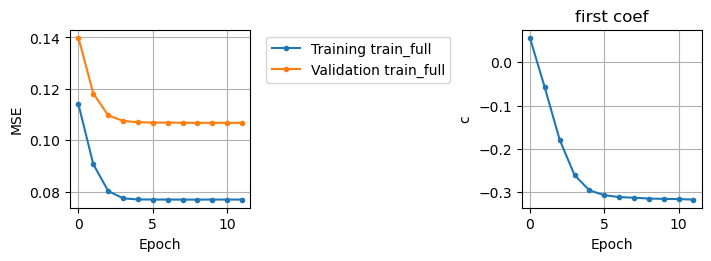

In [31]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(7, 2.5))
exp_model = exp['LinReg']

for i, exp_name in enumerate(exp_model) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[0].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[0], ls=line_styles[i], marker='.', label='Training ' + exp_name)
    ax[0].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[1], ls=line_styles[i], marker='.', label='Validation ' + exp_name)
    ax[1].plot(experiment.logs['coef_train'], color=list(mcolors.TABLEAU_COLORS.values())[0], ls=line_styles[i], marker='.')
ax[0].set(xlabel='Epoch', ylabel='MSE'); ax[0].grid(True)
ax[0].set(ylabel='MSE')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax[1].set(title='first coef', ylabel='c', xlabel='Epoch', yscale='linear');ax[1].grid()
plt.show()

# Fully-connected NN

## Model

The pytorch lightning class describing a model that treats the inputs/outputs by patches of pixels. 

In [32]:
class LitPatchModel(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs, **kwargs):
        super().__init__()
        self.nnModel = nnModel
        # initialization of model parameters with random numbers 
        # for name, param in nnModel.named_parameters():
        #     param.data.normal_(mean=0.0, std=1.0)
        self.inputs = inputs
        self.outputs = outputs
        self.input_patch_size = kwargs['input_patch_size']
        self.output_patch_size = kwargs['output_patch_size']
        self.save_hyperparameters(ignore=['nnModel'])

    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_train', loss, on_step=False, on_epoch=True)
        return loss

    # validation logics (is evaluated during the training, but the data is not used to the optimization loop)
    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    # gives model output in a form of a dictionary of 2d variables
    def predict_step(self, batch, batch_idx, dataloader_idx) :
        output_h = h-2*(self.input_patch_size//2 - self.output_patch_size//2)
        output_w = w-2*(self.input_patch_size//2 - self.output_patch_size//2)
        batch_len = len(batch[self.outputs[0]])
        x = self.transform_input(batch)
        tensor_model_output = self.nnModel(x)
        output_unflatten = torch.permute(tensor_model_output.unflatten(dim=0, sizes=[batch_len,-1]),dims=(0,2,1))
        output_4d = torch.nn.functional.fold(output_unflatten, output_size=(output_h,output_w), kernel_size=self.output_patch_size, \
                                             dilation=1, padding=0, stride=1)
        mask_ones = torch.ones((1,1,output_h,output_w))
        mask_ones = mask_ones.to(batch[self.outputs[0]].device)
        divisor = torch.nn.functional.fold(torch.nn.functional.unfold(mask_ones, kernel_size=self.output_patch_size), \
                                           kernel_size=self.output_patch_size, output_size=(output_h,output_w))
        pred = dict()
        for i, feature in enumerate(self.outputs) :
            pred[feature] = output_4d[:,i].view(-1,output_h,output_w)/divisor.view(1,output_h,output_w)
            # if outputs are normalized then compute also result in the restored units (not normalized)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                pred[not_normalized_feature] = SalinityTemperatureDensityDataset.restore_units(pred[feature], batch, \
                                                                                               not_normalized_feature)
        return pred
        
    # testing logic - to evaluate the model after training
    def test_step(self, batch, batch_idx, dataloader_idx) :
        nb_border_pix = self.input_patch_size//2 - self.output_patch_size//2
        model_output = self.predict_step(batch, batch_idx, dataloader_idx)
        loss = dict(); loss_grad=dict(); corr_coef=dict()
    
        #construct list of features
        list_of_features = list()
        for i, feature in enumerate(self.outputs) :
            list_of_features.append(feature)
            if feature.startswith('normalized_') :
                # compute also for the non-normalized feature
                not_normalized_feature = feature.replace("normalized_", "")
                list_of_features.append(not_normalized_feature)

        for i, feature in enumerate(list_of_features) :
            truth = batch[feature][:,nb_border_pix:-nb_border_pix,nb_border_pix:-nb_border_pix]
            model = model_output[feature]
            loss[feature] = eval_loss(model, truth)
            loss_grad[feature] = eval_loss(finite_diffs_sqr_2d_array(model)[:,1:-1,1:-1], finite_diffs_sqr_2d_array(truth)[:,1:-1,1:-1])
            corr_coef[feature] = torch.corrcoef(torch.vstack((torch.flatten(model).view(1,-1), torch.flatten(truth).view(1,-1))))[1,0]
            self.log_dict({'loss_test_'+feature : loss[feature].mean(), 'loss_grad_test_'+feature : loss_grad[feature].mean(),
                          'corr_coef_'+feature : corr_coef[feature]})
            
    def configure_optimizers(self) :
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer
    
    def transform_input(self, batch) :
        input_4d = torch.transpose(torch.stack([batch[key] for key in self.inputs]), 0, 1)
        # zero padding - will remove border pixels
        # create patches of size 'input_patch_size' and join them into batches
        transform = torch.flatten(torch.permute(torch.nn.functional.unfold(input_4d, kernel_size=self.input_patch_size, \
                                                                           dilation=1, padding=0, stride=1), \
                                                dims=(0,2,1)), end_dim=1).to(torch.float32)
        return transform
    
    def transform_target(self, batch) : 
        # cut-off borders (depends on the size of the inpute patch)
        nb_border_pix = self.input_patch_size//2 - self.output_patch_size//2
        # tranform data into a 4d tensor
        input_4d = torch.transpose(torch.stack([batch[key][:, nb_border_pix:-nb_border_pix, nb_border_pix:-nb_border_pix] \
                                                for key in self.outputs]), 0, 1)
        # create patches of size 'output_patch_size' and join them into batches
        transform = torch.flatten(torch.permute(torch.nn.functional.unfold(input_4d, kernel_size=self.output_patch_size, \
                                                                           dilation=1, padding=0, stride=1), 
                                                dims=(0,2,1)), end_dim=1).to(torch.float32)
        return transform

In [33]:
class FCNN(torch.nn.Module):
    def __init__(self, size_of_input, size_of_output):
        super().__init__()
        self.lin1 = torch.nn.Linear(size_of_input, 50, bias=True)
        self.lin2 = torch.nn.Linear(50, 50, bias=True)
        self.lin3 = torch.nn.Linear(50, size_of_output, bias=True)

    def forward(self, x):
        res = self.lin1(x)
        res = torch.nn.functional.relu(res)
        res = self.lin2(res)
        res = torch.nn.functional.relu(res)
        res = self.lin3(res)
        return res

In [34]:
class FCNN0(torch.nn.Module):
    def __init__(self, size_of_input, size_of_output):
        super().__init__()
        self.lin1 = torch.nn.Linear(size_of_input, size_of_output)

    def forward(self, x):
        res = self.lin1(x)
        return res

## Experiments

In [35]:
model_name = 'FCNN'

In [36]:
list_of_exps = ['patch_1-3', 'patch_3-5']

In [37]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [38]:
exp['FCNN']['patch_1-3']['exp'] = Experiment(pl_class=LitPatchModel, \
                      model=FCNN(5*9,1), \
                      label='FCNN_patched', \
                      version_name='patch_1-3_batch4_grad_loss', \
                      input_features=['normalized_sosstsst', 'normalized_rho_ct_ct', 'normalized_sosaline', 'normalized_rho_sa_ct', 'normalized_rho_sa_sa'], \
                      target_features=['normalized_diff_sigma0_delta_sqr'], 
                      datamodule=datamodule,\
                      max_epochs=50, \
                      limit_train_batches=1.0,\
                      **dict(input_patch_size=3, output_patch_size=1)) 

In [39]:
exp['FCNN']['patch_3-5']['exp'] = Experiment(pl_class=LitPatchModel, \
                      model=FCNN(5*25,9), \
                      label='FCNN_patched', \
                      version_name='patch_3-5_batch4_grad_loss', \
                      input_features=['normalized_sosstsst', 'normalized_rho_ct_ct', 'normalized_sosaline', 'normalized_rho_sa_ct', 'normalized_rho_sa_sa'], \
                      target_features=['normalized_diff_sigma0_delta_sqr'], 
                      datamodule=datamodule,\
                      max_epochs=50, \
                      limit_train_batches=1.0,\
                      **dict(input_patch_size=5, output_patch_size=3)) 

## Training

In [40]:
exp['FCNN']['patch_1-3']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | nnModel | FCNN | 4.9 K 
---------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.020     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//FCNN_patched/patch_1-3_batch4_grad_loss/events.out.tfevents.1666180606.jupyter-anastasiagor.6040.1


In [41]:
exp['FCNN']['patch_3-5']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | nnModel | FCNN | 9.3 K 
---------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//FCNN_patched/patch_3-5_batch4_grad_loss/events.out.tfevents.1666180860.jupyter-anastasiagor.6040.2


logs//FCNN_patched/patch_1-3_batch4_grad_loss/events.out.tfevents.1666180606.jupyter-anastasiagor.6040.1
logs//FCNN_patched/patch_3-5_batch4_grad_loss/events.out.tfevents.1666180860.jupyter-anastasiagor.6040.2


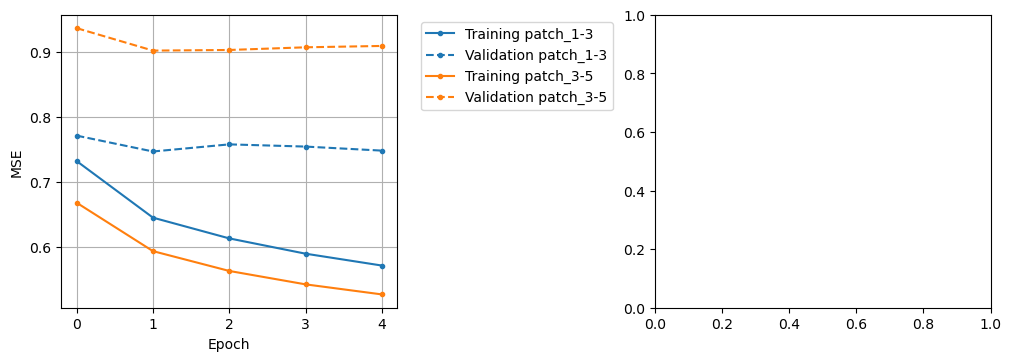

In [42]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
exp_model = exp['FCNN']

for i, exp_name in enumerate(['patch_1-3', 'patch_3-5']) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[0].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[i], \
               ls=line_styles[0], marker='.', label='Training ' + exp_name)
    ax[0].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[i], \
               ls=line_styles[1], marker='.', label='Validation ' + exp_name)
ax[0].set(xlabel='Epoch', ylabel='MSE'); ax[0].grid(True)
ax[0].set(ylabel='MSE')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Convolutional NN model

## Model

In [43]:
class CNN(torch.nn.Module):
    def __init__(self, len_keys_input_CNN, len_keys_targets_CNN, padding1='same', padding2='same', padding_mode='replicate', kernel_size=3):
        super().__init__()
        self.padding1 = padding1
        self.padding2 = padding2
        self.kernel_size = kernel_size
        self.padding_mode = 'replicate'
        
        self.conv1 = torch.nn.Conv2d(in_channels=len_keys_input_CNN, out_channels=64, kernel_size=self.kernel_size, \
                                     padding=self.padding1,  padding_mode=self.padding_mode) 
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=self.kernel_size, padding='same', padding_mode=self.padding_mode) 
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=self.kernel_size, padding='same', padding_mode=self.padding_mode) 
        self.conv4 = torch.nn.Conv2d(64, 64, kernel_size=self.kernel_size, padding='same', padding_mode=self.padding_mode) 
        self.conv5 = torch.nn.Conv2d(64, len_keys_targets_CNN, kernel_size=self.kernel_size, padding='same', padding_mode=self.padding_mode)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)

        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
    
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
    
        x = self.conv5(x)
        
        return x        

In [44]:
class CNN_Model_Class(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs):
        super().__init__()
        self.nnModel = nnModel
        # for name, param in nnModel.named_parameters():
        #     param.data.normal_(mean=0.0, std=0.1)
        self.inputs = inputs
        self.outputs = outputs
        self.save_hyperparameters(ignore=['nnModel'])
        
        # find how many pixels to cut on the borders
        if self.nnModel.padding1 == 'same' :
            self.border_pix_cut = 0
        if self.nnModel.padding1 == 'valid' :
            self.border_pix_cut = self.nnModel.kernel_size//2
        # if self.outputs[0].startswith('diff_') or self.outputs[0].startwith('normalized_diff_') :
        #     self.border_pix_cut+=1       

    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_train', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    def predict_step(self, batch, batch_idx, dataloader_idx) :        
        x = self.transform_input(batch)
        tensor_model_output = self.nnModel(x)
        pred = dict()
        for i, feature in enumerate(self.outputs) :
            pred[feature] = tensor_model_output[:,i,:,:]
            # if outputs are normalized then compute also result in the restored units (not normalized)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                pred[not_normalized_feature] = SalinityTemperatureDensityDataset.restore_units(pred[feature], batch, not_normalized_feature)
        return pred
        
    def test_step(self, batch, batch_idx, dataloader_idx) :
        list_of_features = list()
        model_output = self.predict_step(batch, batch_idx, dataloader_idx)
        loss = dict(); loss_grad=dict()  ; corr_coef=dict()
        
        #construct list of features
        for i, feature in enumerate(self.outputs) :
            list_of_features.append(feature)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                list_of_features.append(not_normalized_feature)
                
        for i, feature in enumerate(list_of_features) :
            truth = batch[feature][:,self.border_pix_cut:-self.border_pix_cut,self.border_pix_cut:-self.border_pix_cut]
            model = model_output[feature]
            loss[feature] = eval_loss(model, truth)
            loss_grad[feature] = eval_loss(finite_diffs_sqr_2d_array(model)[:,1:-1,1:-1], finite_diffs_sqr_2d_array(truth)[:,1:-1,1:-1])
            corr_coef[feature] = torch.corrcoef(torch.vstack((torch.flatten(model).view(1,-1), torch.flatten(truth).view(1,-1))))[1,0]
            self.log_dict({'loss_test_'+feature : loss[feature].mean(), 'loss_grad_test_'+feature : loss_grad[feature].mean(),\
                          'corr_coef_'+feature : corr_coef[feature]})
            
    def configure_optimizers(self) :
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer

    def transform_input(self, batch) :
        return torch.transpose(torch.stack([batch[key] for key in self.inputs]), 0, 1)

    def transform_target(self, batch) : 
        return torch.transpose(torch.stack([batch[key][:,self.border_pix_cut:-self.border_pix_cut,self.border_pix_cut:-self.border_pix_cut] \
                                                for key in self.outputs]), 0, 1)

## Experiments

In [45]:
model_name = 'CNN'

In [46]:
list_of_exps = ['kernel3', 'kernel5']

In [47]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [48]:
exp['CNN']['kernel3']['exp'] = Experiment(pl_class=CNN_Model_Class, \
                      model=CNN(2,1, padding1='valid', kernel_size=3).double(),\
                      label='CNN', \
                      version_name='kernel3_batch4_grad_loss', \
                      input_features=['normalized_sosstsst', 'normalized_rho_ct_ct'], \
                      target_features=['normalized_diff_sigma0_delta_sqr'], 
                      datamodule=datamodule,
                      max_epochs=50, \
                      limit_train_batches=1.0) 

In [49]:
exp['CNN']['kernel5']['exp'] = Experiment(pl_class=CNN_Model_Class, \
                      model=CNN(2, 1, padding1='valid', kernel_size=5).double(),\
                      label='CNN', \
                      version_name='kernel5_batch4_grad_loss', \
                      input_features=['normalized_sosstsst', 'normalized_rho_ct_ct'], \
                      target_features=['normalized_diff_sigma0_delta_sqr'], 
                      datamodule=datamodule,
                      max_epochs=50, \
                      limit_train_batches=1.0) 

## Training

In [50]:
exp['CNN']['kernel3']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | nnModel | CNN  | 112 K 
---------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.450     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//CNN/kernel3_batch4_grad_loss/events.out.tfevents.1666181113.jupyter-anastasiagor.6040.3


In [51]:
exp['CNN']['kernel5']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | nnModel | CNN  | 312 K 
---------------------------------
312 K     Trainable params
0         Non-trainable params
312 K     Total params
1.249     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//CNN/kernel5_batch4_grad_loss/events.out.tfevents.1666181615.jupyter-anastasiagor.6040.4


logs//CNN/kernel3_batch4_grad_loss/events.out.tfevents.1666181113.jupyter-anastasiagor.6040.3
logs//CNN/kernel5_batch4_grad_loss/events.out.tfevents.1666181615.jupyter-anastasiagor.6040.4


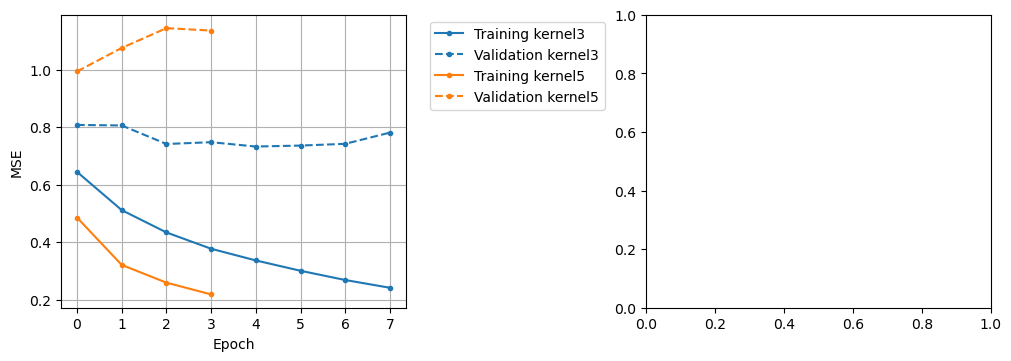

In [52]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
exp_model = exp['CNN']

for i, exp_name in enumerate(['kernel3', 'kernel5']) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[0].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[i], \
               ls=line_styles[0], marker='.', label='Training ' + exp_name)
    ax[0].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[i], \
               ls=line_styles[1], marker='.', label='Validation ' + exp_name)
ax[0].set(xlabel='Epoch', ylabel='MSE'); ax[0].grid(True)
ax[0].set(ylabel='MSE')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Compare results

In [53]:
%%time
test_datamodule = datamodule

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


In [54]:
list_of_models = ['LinReg', 'CNN', 'FCNN']

In [ ]:
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        model = exp_dict['exp'].NN
        exp_dict['best_model'] = model.load_from_checkpoint(nnModel=model.nnModel, \
                                                            checkpoint_path=exp_dict['exp'].get_checkpoint_path(), \
                                                            **exp_dict['exp'].kwargs)
        trainer = pl.Trainer(accelerator='gpu', devices=1)
        print(model_name + ' ' + exp_name)
        test_dict = trainer.test(exp_dict['best_model'], datamodule=test_datamodule)
        exp_dict['loss_vs_dataset'] = dict()
        exp_dict['loss_diffs_vs_dataset'] = dict()
        exp_dict['corr_coef_vs_dataset'] = dict()
        for feature in ['diff_sigma0_delta_sqr', 'normalized_diff_sigma0_delta_sqr'] :
            if 'loss_test_'+feature+'/dataloader_idx_0' in test_dict[0] :
                exp_dict['loss_vs_dataset'][feature] = [test_dict[ds]['loss_test_'+feature+'/dataloader_idx_'+str(ds)] \
                                                        for ds in range(len(data_dict))]
            if 'loss_grad_test_'+feature+'/dataloader_idx_0' in test_dict[0] :
                exp_dict['loss_diffs_vs_dataset'][feature] = [test_dict[ds]['loss_grad_test_'+feature+'/dataloader_idx_'+str(ds)] \
                                                              for ds in range(len(data_dict))]
            if 'corr_coef_'+feature+'/dataloader_idx_0' in test_dict[0] :
                exp_dict['corr_coef_vs_dataset'][feature] = [test_dict[ds]['corr_coef_'+feature+'/dataloader_idx_'+str(ds)] \
                                                          for ds in range(len(data_dict))]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LinReg train_full


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 1, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, te

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                  Test metric                                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        corr_coef_diff_sigma0_delta_sqr                      0.6475274126785345
  corr_coef_normalized_diff_sigma0_delta_sqr                  0.647527412678534
     loss_grad_test_diff_sigma0_delta_sqr                  3.2250096397970665e-13
loss_grad_test_normalized_diff_sigma0_delta_sqr              10.712648768928194
        loss_test_diff_sigma0_delta_sqr                    1.3139901868981655e-07
  loss_test_normalized_diff_sigma0_delta_sqr                 0.7573123624495715
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CNN kernel3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 1, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, te

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                  Test metric                                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        corr_coef_diff_sigma0_delta_sqr                      0.6808557496788106
  corr_coef_normalized_diff_sigma0_delta_sqr                 0.6808557496788104
     loss_grad_test_diff_sigma0_delta_sqr                  3.0351828776785665e-13
loss_grad_test_normalized_diff_sigma0_delta_sqr              10.082093311209993
        loss_test_diff_sigma0_delta_sqr                     1.240931656434564e-07
  loss_test_normalized_diff_sigma0_delta_sqr                 0.7152054054462674
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CNN kernel5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 1, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, te

Testing: 0it [00:00, ?it/s]

## Image example

In [ ]:
test_dl = test_datamodule.test_dataloader()[1]

In [ ]:
test_di = iter(test_dl)

In [ ]:
sample = next(test_di)

In [ ]:
idx = 0 #index inside the batch

In [ ]:
snapshot_true_error = np.squeeze(sample['diff_sigma0_delta_sqr'][idx])[1:-1,1:-1]

In [ ]:
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        model = exp_dict['best_model']
        exp_dict['snapshot'] = np.squeeze((model.predict_step(sample, idx, 0)['diff_sigma0_delta_sqr'][idx]).detach().numpy())

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,8), constrained_layout=True)
fig.suptitle('Example of density error fields (dimensional)')

for i, model_name in enumerate(list_of_models) :
    img = ax[i,0].imshow(snapshot_true_error, cmap='ocean_r')
    fig.colorbar(img, ax=ax[i,0])
    ax[i,0].set(title='True density error')
    color_min = img.colorbar.vmin
    color_max = img.colorbar.vmax
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        img = ax[i,j+1].imshow(exp_dict['snapshot'], cmap='ocean_r', vmin=color_min, vmax=color_max)
        fig.colorbar(img, ax=ax[i,j+1])
        ax[i,j+1].set(title=model_name+' '+exp_name, xlabel='x')
plt.show()

## Compare MSE across datasets

### MSE 

In [ ]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0))
fig.suptitle('MSE of absolute (non-normalized) values of density error')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'diff_sigma0_delta_sqr'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_vs_dataset'].keys()) :
                ax[region].bar(x[i]+j*bar_width, exp_dict['loss_vs_dataset'][feature][region], width=bar_width, color=list(mcolors.TABLEAU_COLORS.values())[bar_counter],\
                              label=exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Correlation coefficient

In [ ]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0))
fig.suptitle('Correlation coefficient between model and truth')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'normalized_diff_sigma0_delta_sqr'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_vs_dataset'].keys()) :
                ax[region].bar(x[i]+j*bar_width, exp_dict['corr_coef_vs_dataset'][feature][region], width=bar_width, color=list(mcolors.TABLEAU_COLORS.values())[bar_counter],\
                              label=exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()